In [1]:
import torch
import pandas as pd
import seaborn as sns
from functorch import vmap
from torch.distributions.multivariate_normal import MultivariateNormal
from BASQ.experiment.ecm import CanonicalECMOneRCs, CanonicalECMTwoRCs, CanonicalECMThreeRCs
from BASQ._basq import BASQ
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)  # random seed

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


# Note
- the number of samples per iteration is 100. you can change this with "./BASQ/_parameters.py"
- you can find more information on ECM modelling at "./BASQ/experiment/ecm.py"
- calculation of evidence is expensive. If you wish for faster computation, you can omit the function showing evidence over each iteration by "show_progress = False".
- n_batch is quite an ad-hoc parameter. For more rational stopping criterion is the variance of evidence. A variance of evidence shows the level of convergence. Ideally, the model selection should be performed with a similar variance level. But, poor model identifiability sometimes causes large variance and makes it impossible to improve to the same level as a better model.
- The variance sometimes goes up. This is due to multimodality in log-likelihood and jumping into a better peak.

## To do
- set the convergence criterion
- seek for faster uncertatinty sampling methods

# Case 1: 2 RC-pairs
## 1. set the ground truth spectrum

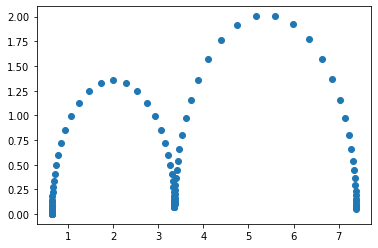

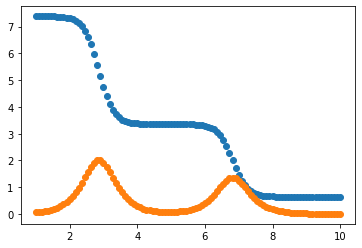

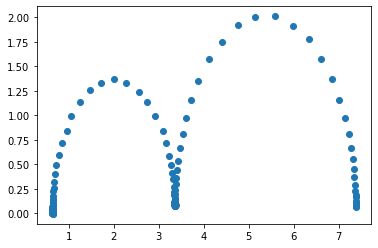

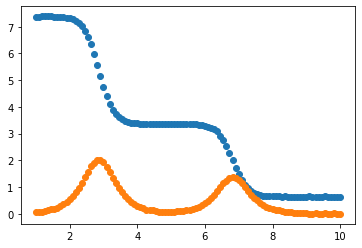

In [2]:
# dataset conditions
n_data = 100  # number of data points
f = torch.logspace(1,10,n_data)  # frequency [Hz]
omega = 2 * torch.pi * f  # angular frequency [rad/s]
params_true = torch.tensor([2,-0.5,-1,0,0.5, 2.3])  # true parameter set

# ECM parameters
rt, r1, t1, r2, t2, sigma = params_true  # decompose the parameters
TwoRCsModel = CanonicalECMTwoRCs(rt, r1, t1, r2, t2, sigma, omega)  # set ECM
TwoRCsModel.plot()  # first two plots are the simulated results, the second ones are the sim + noise

## 2. set the BQ model

In [3]:
# Bayesian Inference Modelling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mu_pi = params_true * 0.9  # mean vector of Gaussian prior
cov_pi = 0.5 * torch.diag(torch.ones(len(mu_pi))).float()  # covariance matrix of Gaussian prior
prior = MultivariateNormal(mu_pi,cov_pi)  # Gaussian prior function
true_loglikelihood = vmap(TwoRCsModel)  # True log-likelihood function

# Initial guess
dev = 1e-2  # the deviance from the perfect initial guess (true parameters)
train_x = torch.tile(params_true, (2, 1)) * (1 + dev*torch.rand(2)).unsqueeze(1)  # two initial guess locations
train_y = true_loglikelihood(train_x)  # two initial guess values

## 3. run BASQ

In [4]:
n_batch = 10  # the number of BASQ iteration

basq = BASQ(
    train_x,  # initial guess locations
    train_y,  # initial guess values
    prior,  # prior function
    true_loglikelihood,  # true log-likelihood function
    device,  # torch.device
)

results = basq.run(n_batch)  # run BASQ
print(
    "overhead: " + str(results[:, 0].sum().item()) + " [s]\n"
    + "overhead per sample: " + str(results[:, 0].sum().item() / basq.batch_size / n_batch)
    + " [s]\n"
    + "final logE[Z|y]: " + str(results[-1, 1].item()) + "\n"
    + "final logVar[Z|y]: " + str(results[-1, 2].item()) + "\n"
)

BQ model: mmlt | kernel: RBF | sampler: uncertainty | sampling_method: exact | optimiser: BoTorch
logE[Z|y]: -129.4433135986328  logVar[Z|y]: -21.183425903320312
logE[Z|y]: 610.908935546875  logVar[Z|y]: -23.56822967529297
logE[Z|y]: 684.4708251953125  logVar[Z|y]: -26.382402420043945
logE[Z|y]: 683.5391845703125  logVar[Z|y]: -28.526941299438477
logE[Z|y]: 683.4307250976562  logVar[Z|y]: -28.945301055908203
logE[Z|y]: 703.8037719726562  logVar[Z|y]: -27.646108627319336
logE[Z|y]: 708.0028076171875  logVar[Z|y]: -24.402626037597656
logE[Z|y]: 709.5171508789062  logVar[Z|y]: -24.526687622070312
logE[Z|y]: 710.1185302734375  logVar[Z|y]: -23.017295837402344
logE[Z|y]: 710.3795776367188  logVar[Z|y]: -22.473875045776367
overhead: 226.79202270507812 [s]
overhead per sample: 0.22679202270507814 [s]
final logE[Z|y]: 710.3795776367188
final logVar[Z|y]: -22.473875045776367



# 4. check posterior
### 4.1 check marginal posteriors

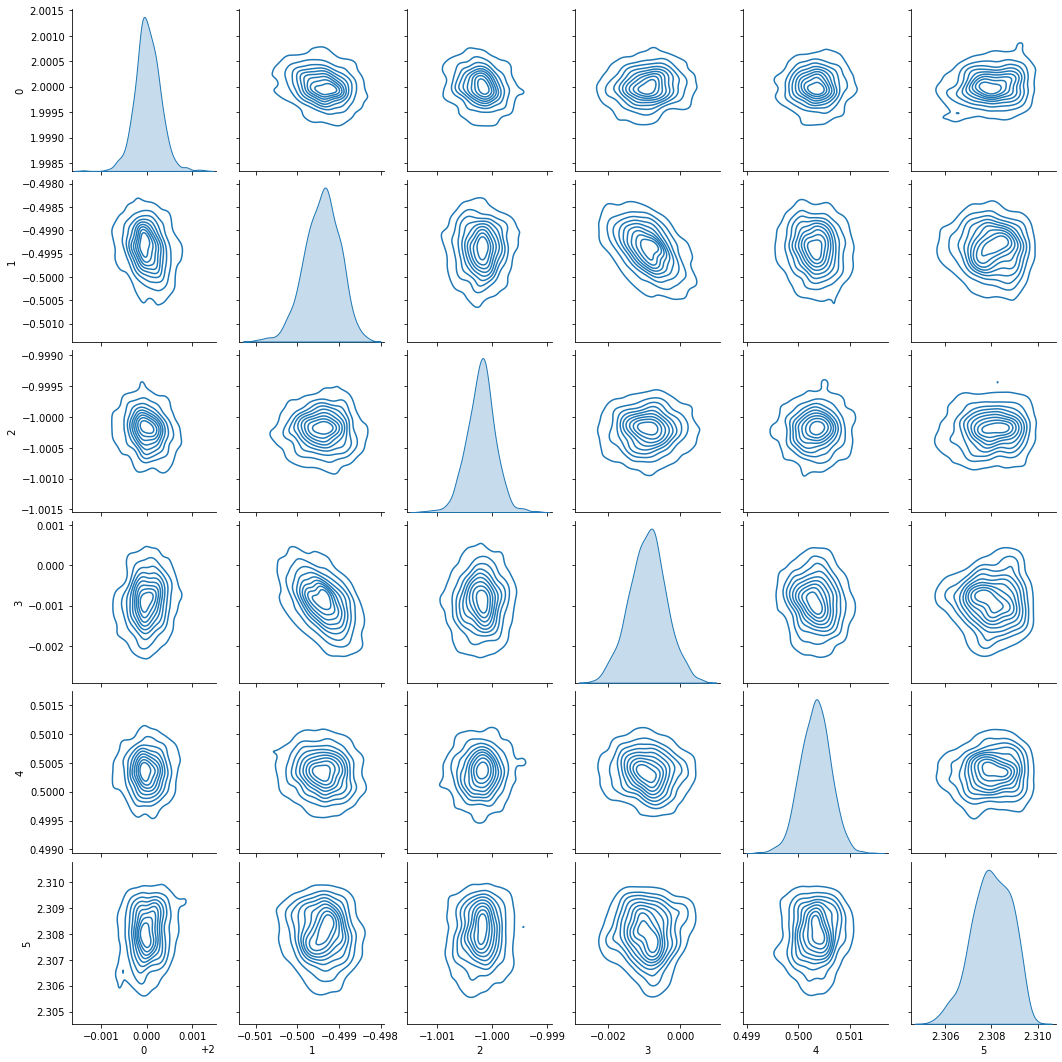

In [5]:
n_samples = 1000 # number of posterior samples
posterior_samples = basq.posterior.sample(n_samples)  # generate posterior samples
df = pd.DataFrame(posterior_samples.numpy())  # convert pandas dataframe
pairplot = sns.pairplot(df, kind="kde")  # pairplot of the posterior samples 

### 4.2 check predictive posterior

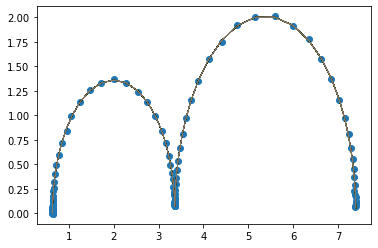

In [6]:
for i in range(n_samples):
    TwoRCsModel(posterior_samples[i])
    plt.plot(TwoRCsModel.real_part(), TwoRCsModel.imarginary_part(), linewidth=0.5, alpha=0.1)
plt.scatter(TwoRCsModel.reZ, TwoRCsModel.imZ)
plt.show()

### 4.3 check MAP estimation

PDF of posterior at MAP: 615.8878784179688
tensor([ 2.0000e+00, -4.9940e-01, -1.0002e+00, -8.9164e-04,  5.0034e-01,
         2.3078e+00])
tensor([ 2.0000, -0.5000, -1.0000,  0.0000,  0.5000,  2.3000])


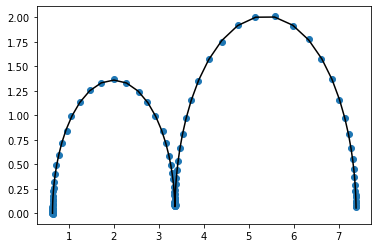

In [7]:
n_seed = 10000 # number of random seeds
X_MAP = basq.posterior.MAP_estimation(n_seed)  # estimate MAP location
print(X_MAP)
print(params_true)
TwoRCsModel(X_MAP)
plt.plot(TwoRCsModel.real_part(), TwoRCsModel.imarginary_part(), color="black")
plt.scatter(TwoRCsModel.reZ, TwoRCsModel.imZ)

# Case 2: 1 RC-pair
## 1. set the RC model

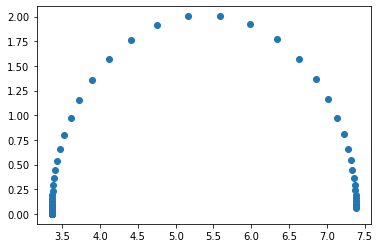

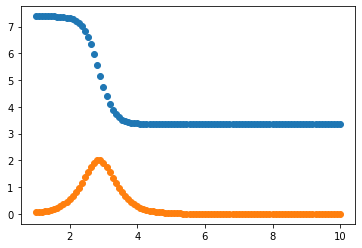

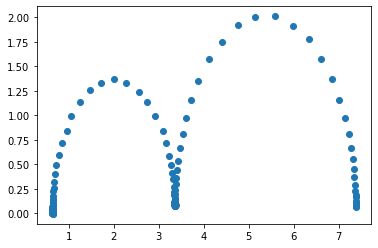

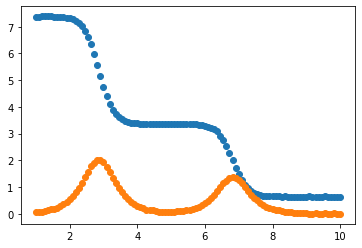

In [8]:
theta = torch.tensor([2., -0.5, -1., 2.3])  # initial guess of parameters
rt, r1, t1, sigma = theta  # decompose the parameters
OneRCModel = CanonicalECMOneRCs(rt, r1, t1, sigma, omega)  # set One RC-pair model
OneRCModel.set_true_data(TwoRCsModel.reZ, TwoRCsModel.imZ)  # set the ground truth from Two RC-pair model
OneRCModel.plot()  # visualise the initial guess

## 2. set the BQ model

In [9]:
# Bayesian Inference Modelling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mu_pi = theta * 0.9  # mean vector of Gaussian prior
cov_pi = 0.5 * torch.diag(torch.ones(len(mu_pi))).float()  # covariance matrix of Gaussian prior
prior = MultivariateNormal(mu_pi,cov_pi)  # Gaussian prior function
true_loglikelihood = vmap(OneRCModel)  # True log-likelihood function

# Initial guess
dev = 1e-2  # the deviance from the perfect initial guess (true parameters)
train_x = torch.tile(theta, (2, 1)) * (1 + dev*torch.rand(2)).unsqueeze(1)  # two initial guess locations
train_y = true_loglikelihood(train_x)  # two initial guess values

## 3. run BASQ

In [10]:
n_batch = 10  # the number of BASQ iteration

basq = BASQ(
    train_x,  # initial guess locations
    train_y,  # initial guess values
    prior,  # prior function
    true_loglikelihood,  # true log-likelihood function
    device,  # torch.device
)

results = basq.run(n_batch)  # run BASQ
print(
    "overhead: " + str(results[:, 0].sum().item()) + " [s]\n"
    + "overhead per sample: " + str(results[:, 0].sum().item() / basq.batch_size / n_batch)
    + " [s]\n"
    + "final logE[Z|y]: " + str(results[-1, 1].item()) + "\n"
    + "final logVar[Z|y]: " + str(results[-1, 2].item()) + "\n"
)

BQ model: mmlt | kernel: RBF | sampler: uncertainty | sampling_method: exact | optimiser: BoTorch
logE[Z|y]: -3155381.75  logVar[Z|y]: -20.990751266479492
logE[Z|y]: -3006973.25  logVar[Z|y]: -20.23843002319336
logE[Z|y]: -2798337.0  logVar[Z|y]: -5.355035305023193
logE[Z|y]: -2199374.75  logVar[Z|y]: -6.127266883850098
logE[Z|y]: -1610496.0  logVar[Z|y]: -11.539447784423828
logE[Z|y]: -772052.0  logVar[Z|y]: -11.5423002243042
logE[Z|y]: -429274.96875  logVar[Z|y]: -11.512774467468262
logE[Z|y]: -243595.78125  logVar[Z|y]: -12.916984558105469
logE[Z|y]: -137153.25  logVar[Z|y]: -8.034807205200195
logE[Z|y]: -68931.3671875  logVar[Z|y]: -12.985801696777344
overhead: 99.01639556884766 [s]
overhead per sample: 0.09901639556884766 [s]
final logE[Z|y]: -68931.3671875
final logVar[Z|y]: -12.985801696777344



# 4. check posterior
### 4.1 check marginal posteriors

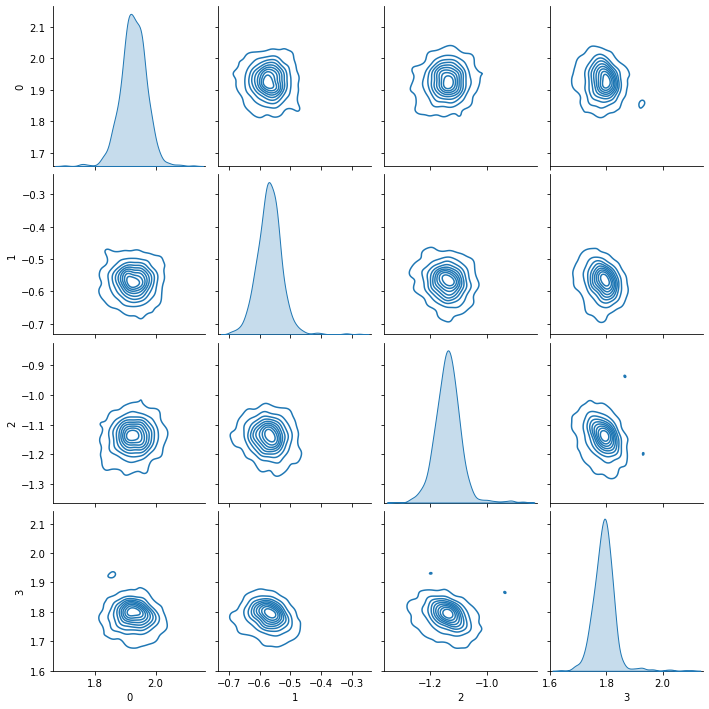

In [11]:
n_samples = 1000 # number of posterior samples
posterior_samples = basq.posterior.sample(n_samples)  # generate posterior samples
df = pd.DataFrame(posterior_samples.numpy())  # convert pandas dataframe
pairplot = sns.pairplot(df, kind="kde")  # pairplot of the posterior samples 

### 4.2 check predictive posterior

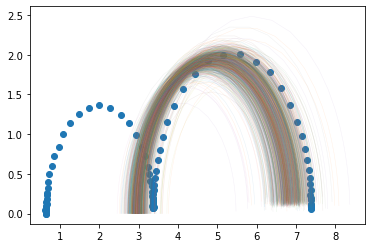

In [12]:
for i in range(n_samples):
    OneRCModel(posterior_samples[i])
    plt.plot(OneRCModel.real_part(), OneRCModel.imarginary_part(), linewidth=0.5, alpha=0.1)
plt.scatter(OneRCModel.reZ, OneRCModel.imZ)
plt.show()

### 4.3 check MAP estimation

PDF of posterior at MAP: 30060.4296875
tensor([ 1.9270, -0.5781, -1.1597,  1.7805])
tensor([ 2.0000, -0.5000, -1.0000,  2.3000])


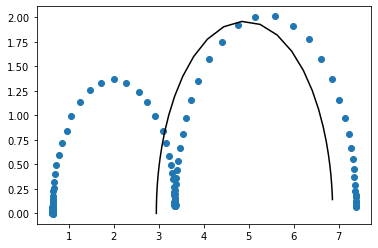

In [13]:
n_seed = 10000 # number of random seeds
X_MAP = basq.posterior.MAP_estimation(n_seed)  # estimate MAP location
print(X_MAP)
print(theta)
OneRCModel(X_MAP)
plt.plot(OneRCModel.real_part(), OneRCModel.imarginary_part(), color="black")
plt.scatter(OneRCModel.reZ, OneRCModel.imZ)

# Case 3: 3 RC-pairs
## 1. set the RC model

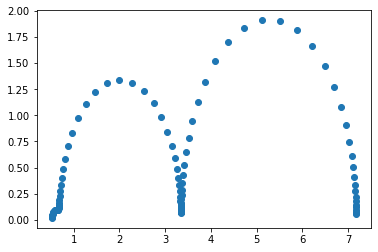

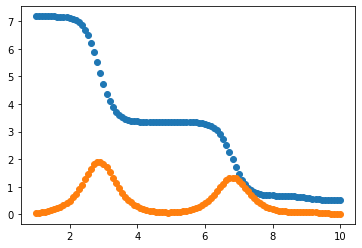

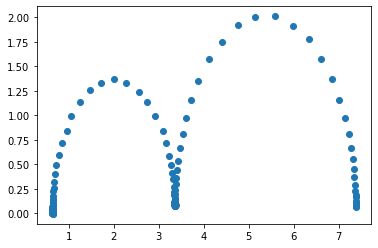

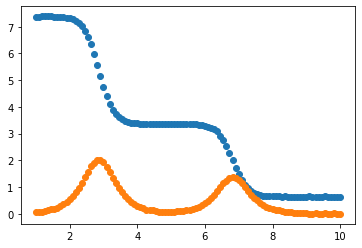

In [14]:
theta = torch.tensor([ 7.1785, -0.4653, -0.9957, -0.0108,  0.4984,  1.3413,  1.3310,  1.4445])  # initial guess of parameters
rt, r1, t1, r2, t2, r3, t3, sigma = theta  # decompose the parameters
ThreeRCsModel = CanonicalECMThreeRCs(rt, r1, t1, r2, t2, r3, t3, sigma, omega)  # set Three RC-pairs model
ThreeRCsModel.set_true_data(TwoRCsModel.reZ, TwoRCsModel.imZ)  # set the ground truth from Two RC-pair model
ThreeRCsModel.plot()  # visualise the initial guess

## 2. set the BQ model

In [15]:
# Bayesian Inference Modelling
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mu_pi = theta * 0.9  # mean vector of Gaussian prior
cov_pi = 0.5 * torch.diag(torch.ones(len(mu_pi))).float()  # covariance matrix of Gaussian prior
prior = MultivariateNormal(mu_pi,cov_pi)  # Gaussian prior function
true_loglikelihood = vmap(ThreeRCsModel)  # True log-likelihood function

# Initial guess
dev = 1e-2  # the deviance from the perfect initial guess (true parameters)
train_x = torch.tile(theta, (2, 1)) * (1 + dev*torch.rand(2)).unsqueeze(1)  # two initial guess locations
train_y = true_loglikelihood(train_x)  # two initial guess values

## 3. run BASQ

In [16]:
n_batch = 10  # the number of BASQ iteration

basq = BASQ(
    train_x,  # initial guess locations
    train_y,  # initial guess values
    prior,  # prior function
    true_loglikelihood,  # true log-likelihood function
    device,  # torch.device
)

results = basq.run(n_batch)  # run BASQ
print(
    "overhead: " + str(results[:, 0].sum().item()) + " [s]\n"
    + "overhead per sample: " + str(results[:, 0].sum().item() / basq.batch_size / n_batch)
    + " [s]\n"
    + "final logE[Z|y]: " + str(results[-1, 1].item()) + "\n"
    + "final logVar[Z|y]: " + str(results[-1, 2].item()) + "\n"
)

BQ model: mmlt | kernel: RBF | sampler: uncertainty | sampling_method: exact | optimiser: BoTorch
logE[Z|y]: 221.12757873535156  logVar[Z|y]: -9.573582649230957
logE[Z|y]: 228.53640747070312  logVar[Z|y]: -18.731094360351562
logE[Z|y]: 224.3201446533203  logVar[Z|y]: -32.191993713378906
logE[Z|y]: 258.25933837890625  logVar[Z|y]: -29.272825241088867
logE[Z|y]: 256.34246826171875  logVar[Z|y]: -34.09025192260742
logE[Z|y]: 266.3331298828125  logVar[Z|y]: -32.4041862487793
logE[Z|y]: 280.582275390625  logVar[Z|y]: -31.193506240844727
logE[Z|y]: 302.26092529296875  logVar[Z|y]: -32.66872787475586
logE[Z|y]: 315.29193115234375  logVar[Z|y]: -33.03586959838867
logE[Z|y]: 324.224365234375  logVar[Z|y]: -34.231449127197266
overhead: 273.35797119140625 [s]
overhead per sample: 0.27335797119140626 [s]
final logE[Z|y]: 324.224365234375
final logVar[Z|y]: -34.231449127197266



# 4. check posterior
### 4.1 check marginal posteriors

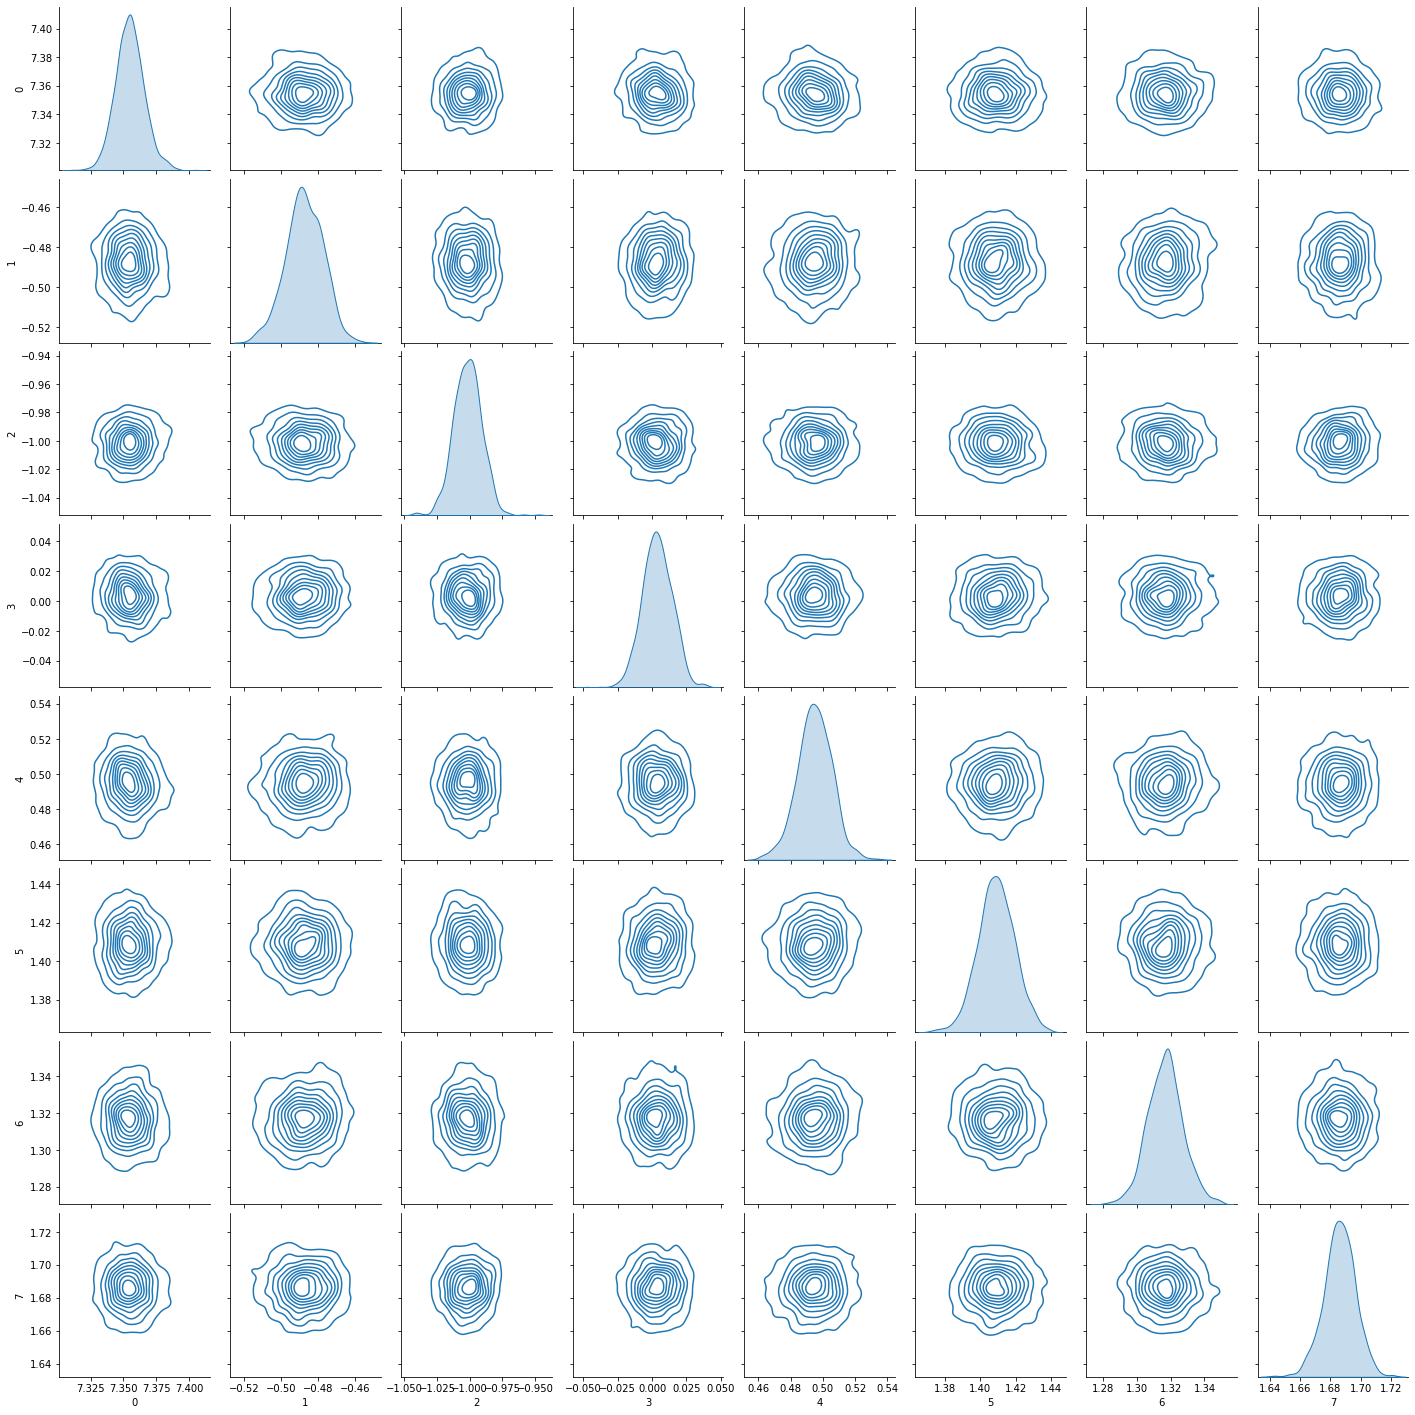

In [17]:
n_samples = 1000 # number of posterior samples
posterior_samples = basq.posterior.sample(n_samples)  # generate posterior samples
df = pd.DataFrame(posterior_samples.numpy())  # convert pandas dataframe
pairplot = sns.pairplot(df, kind="kde")  # pairplot of the posterior samples 

### 4.2 check predictive posterior

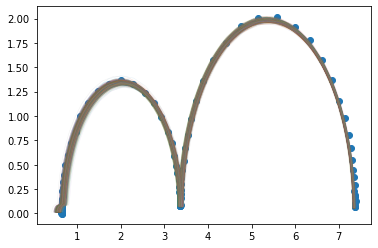

In [18]:
for i in range(n_samples):
    ThreeRCsModel(posterior_samples[i])
    plt.plot(ThreeRCsModel.real_part(), ThreeRCsModel.imarginary_part(), linewidth=0.5, alpha=0.1)
plt.scatter(ThreeRCsModel.reZ, ThreeRCsModel.imZ)
plt.show()

### 4.3 check MAP estimation

PDF of posterior at MAP: 5033.6982421875
tensor([ 7.3511e+00, -4.8627e-01, -1.0008e+00,  6.6822e-03,  4.9696e-01,
         1.4080e+00,  1.3160e+00,  1.6858e+00])
tensor([ 7.1785, -0.4653, -0.9957, -0.0108,  0.4984,  1.3413,  1.3310,  1.4445])


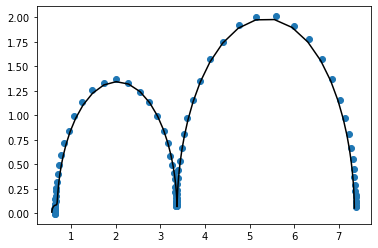

In [19]:
n_seed = 10000 # number of random seeds
X_MAP = basq.posterior.MAP_estimation(n_seed)  # estimate MAP location
print(X_MAP)
print(theta)
ThreeRCsModel(X_MAP)
plt.plot(ThreeRCsModel.real_part(), ThreeRCsModel.imarginary_part(), color="black")
plt.scatter(ThreeRCsModel.reZ, ThreeRCsModel.imZ)